In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import itertools

import matplotlib.pyplot as plt
import lightgbm as lgb
from pylab import rcParams
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px


In [2]:
train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])

# Sales

Our main objective is, predicting store sales for each product family. For this reason, sales column should be examined more seriously. We need to learn everthing such as seasonality, trends, anomalies, similarities with other time series and so on.

In [14]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


Text(0.5, 1.0, 'Store-1 Sales Data aggreagted at Month Level')

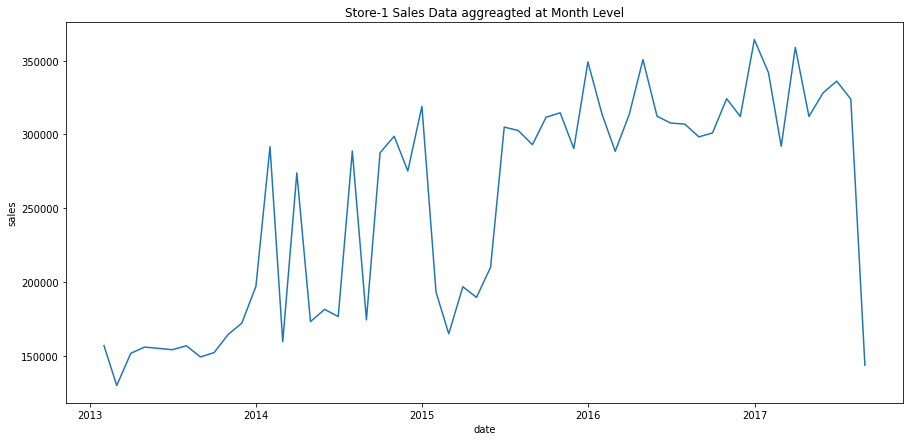

In [15]:
store1_agg = train.loc[train['store_nbr']==1].groupby(['date'])['sales'].sum()
store1_agg.index = pd.to_datetime(store1_agg.index)

#Aggregate the Data on a Monthly basis.
store1_agg_monthly = store1_agg.resample('M').sum()

plt.figure(figsize=(15,7))
sns.lineplot(data=store1_agg_monthly)
plt.title("Store-1 Sales Data aggreagted at Month Level")

<Figure size 1080x504 with 0 Axes>

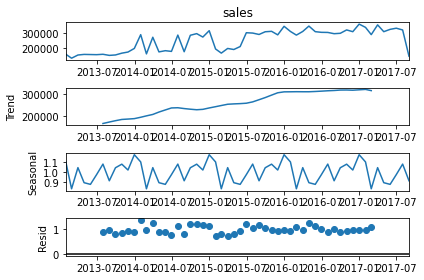

In [16]:
plt.figure(figsize=(15,7))
seasonal_decompose(store1_agg_monthly,model="multiplicative",period=12).plot()
plt.show()

## Correlations among stores

In [17]:
a = train[['store_nbr', 'sales']]
a['ind'] = 1
a['ind'] = a.groupby('store_nbr').ind.cumsum().values
a = pd.pivot(a, index='ind', columns='store_nbr', values='sales').corr()
mask = np.triu(a.corr())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:xlabel='store_nbr', ylabel='store_nbr'>

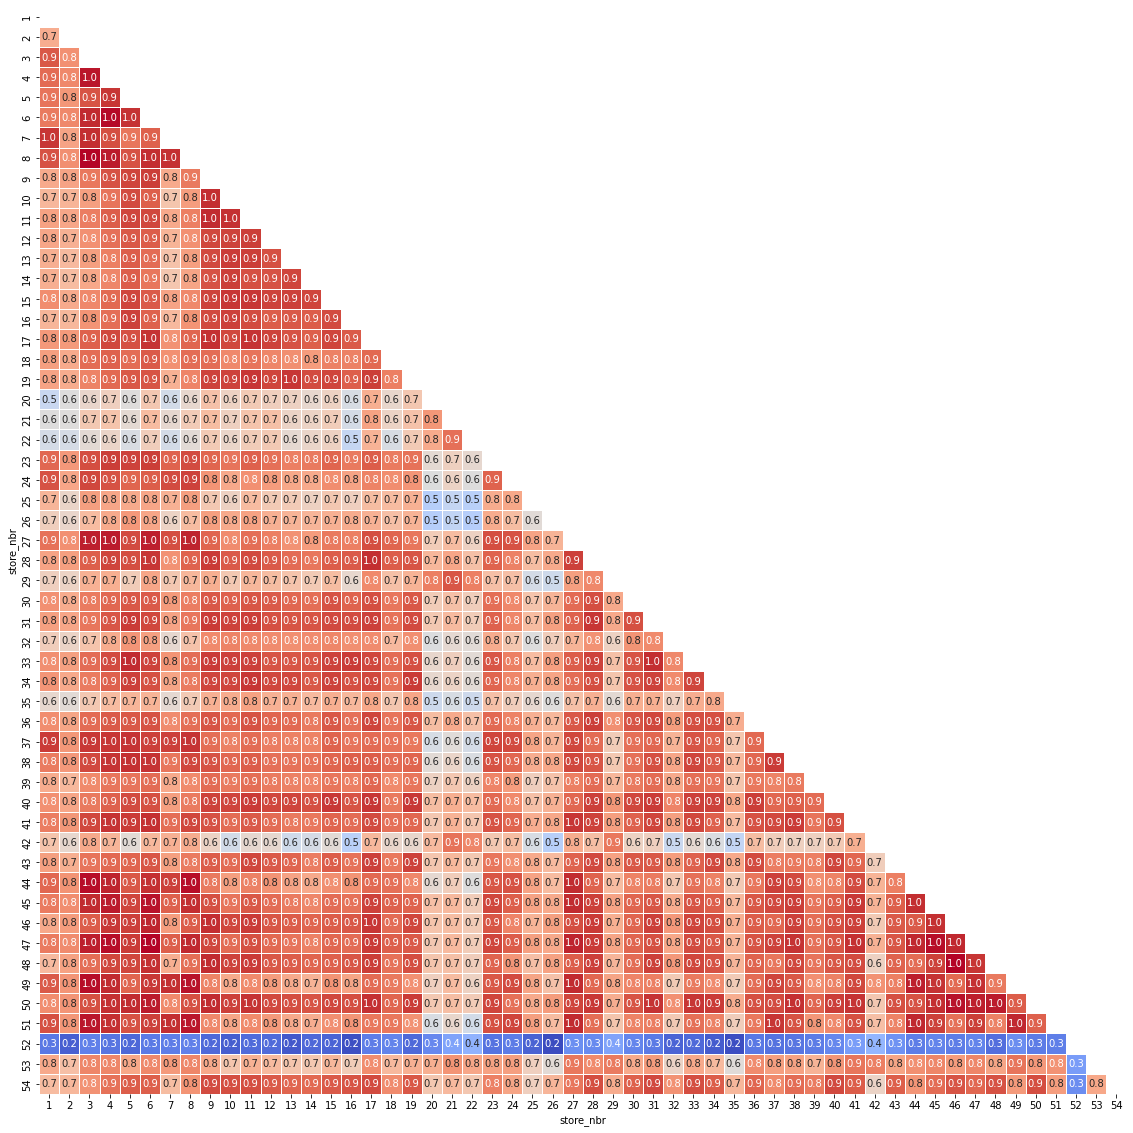

In [18]:
plt.figure(figsize=(20,20))
sns.heatmap(a, 
            annot=True, 
            fmt='.1f', 
            cmap='coolwarm', 
            square=True, 
            mask=mask, 
            linewidths=1, 
            cbar=False) 

In [19]:
# There is a graph that shows us daily total sales below

a = train.set_index('date').groupby('store_nbr').resample('D').sales.sum().reset_index()
a.sample(15)

,store_nbr,date,sales
50246,30,2016-07-18,4958.167969
70659,42,2016-12-22,16978.052734
18331,11,2016-12-22,39085.734375
36058,22,2014-09-03,0.000000
51440,31,2015-03-12,7508.226074
68268,41,2015-01-19,6249.622070
48278,29,2015-10-12,8701.587891
71787,43,2015-06-11,9131.401367
46952,28,2016-10-08,14652.294922
42630,26,2014-03-07,4554.976562


In [20]:
px.line(a, x = "date", y= "sales", title = "Daily total sales of the stores")

# LightGBM Autoregressor model

## Time Series Train-Test split

In [21]:
! pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 4.9 MB/s eta 0:00:00


In [22]:
from sktime.forecasting.model_selection import (temporal_train_test_split)

store1_agg_monthly.index = store1_agg_monthly.index.to_period('M') 
y_train, y_test = temporal_train_test_split(store1_agg_monthly, test_size=0.2)

In [23]:
y_train.head()

date
2013-01    156864.203125
2013-02    129814.328125
2013-03    151666.234375
2013-04    155848.500000
2013-05    154965.656250
Freq: M, Name: sales, dtype: float32

In [24]:
y_test.tail()

date
2017-04    312155.21875
2017-05    328151.90625
2017-06    336087.50000
2017-07    323936.06250
2017-08    143508.90625
Freq: M, Name: sales, dtype: float32

## Detrender

In [25]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
import lightgbm as lgb
from pylab import rcParams
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.forecasting.compose import (TransformedTargetForecaster, make_reduction)
from sktime.forecasting.base import ForecastingHorizon

In [26]:
from sktime.utils.plotting import plot_series

forecaster = PolynomialTrendForecaster(degree=1) 
transformer = Detrender(forecaster=forecaster)

#Get the residuals after fitting a linear trend
y_resid = transformer.fit_transform(y_train)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='sales'>)

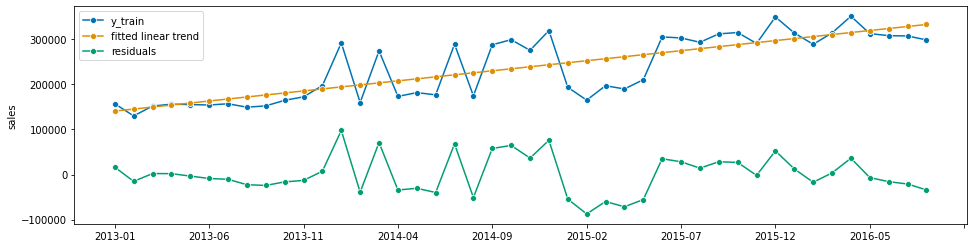

In [27]:
# Internally, the Detrender uses the in-sample predictions
# of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train))  # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)
plot_series(y_train, y_pred, y_resid, labels=["y_train", "fitted linear trend", "residuals"])

## Deseasonalize

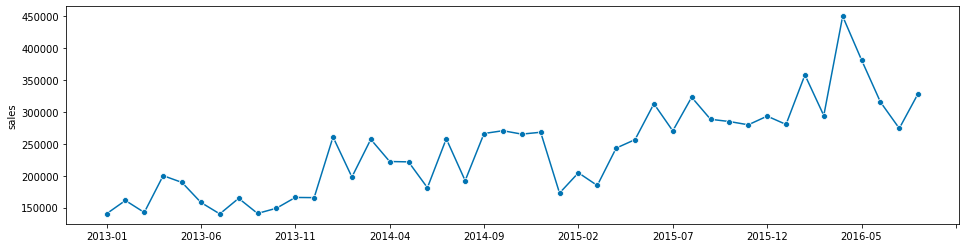

In [28]:
deseasonalizer = Deseasonalizer(model='multiplicative', sp=12)
plot_series(deseasonalizer.fit_transform(y_train))
seasonal = deseasonalizer.fit_transform(y_train)

In [29]:
regressor = lgb.LGBMRegressor()

#hyper-paramter to set recursive strategy
forecast = make_reduction(estimator=regressor, window_length=4, strategy='recursive')

## Create Pipeline

In [30]:
def get_transformed_target_forecaster(alpha,params):
    
    regressor = lgb.LGBMRegressor(alpha = alpha,**params)
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
            ("forecast", make_reduction(estimator=regressor, window_length=4, strategy="recursive"))
        ]
    )
    return forecaster

In [31]:
params = {'objective':'quantile'}

quantiles = [.1, .5, .9]
forecasts = []
for alpha in quantiles:
    forecaster = get_transformed_target_forecaster(alpha,params)
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    y_pred.index.name='date'
    y_pred.name=f"predicted_sales_q_{alpha}"
    forecasts.append(y_pred)
    
store1_agg_monthly.index.name = 'date'
store1_agg_monthly.name = 'original'
forecasts.append(store1_agg_monthly)

In [32]:
error = mean_squared_log_error(y_test, y_pred)
error

0.158973727564277

## Final Plotting of Forecasts

In [33]:
plot_data = pd.melt(pd.concat(forecasts,axis=1).reset_index(), id_vars=['date'],\
        value_vars=['predicted_sales_q_0.1', 'predicted_sales_q_0.5',
                   'predicted_sales_q_0.9','original'])
plot_data

,date,variable,value
0,2013-01,predicted_sales_q_0.1,NaN
1,2013-02,predicted_sales_q_0.1,NaN
2,2013-03,predicted_sales_q_0.1,NaN
3,2013-04,predicted_sales_q_0.1,NaN
4,2013-05,predicted_sales_q_0.1,NaN
...,...,...,...
219,2017-04,original,312155.21875
220,2017-05,original,328151.90625
221,2017-06,original,336087.50000
222,2017-07,original,323936.06250


In [34]:
plot_data['date'] = pd.to_datetime(plot_data['date'].astype(str).to_numpy())
plot_data['if_original'] = plot_data['variable'].apply(lambda x: 'original' if x=='original' else 'predicted')
plot_data

,date,variable,value,if_original
0,2013-01-01,predicted_sales_q_0.1,NaN,predicted
1,2013-02-01,predicted_sales_q_0.1,NaN,predicted
2,2013-03-01,predicted_sales_q_0.1,NaN,predicted
3,2013-04-01,predicted_sales_q_0.1,NaN,predicted
4,2013-05-01,predicted_sales_q_0.1,NaN,predicted
...,...,...,...,...
219,2017-04-01,original,312155.21875,original
220,2017-05-01,original,328151.90625,original
221,2017-06-01,original,336087.50000,original
222,2017-07-01,original,323936.06250,original


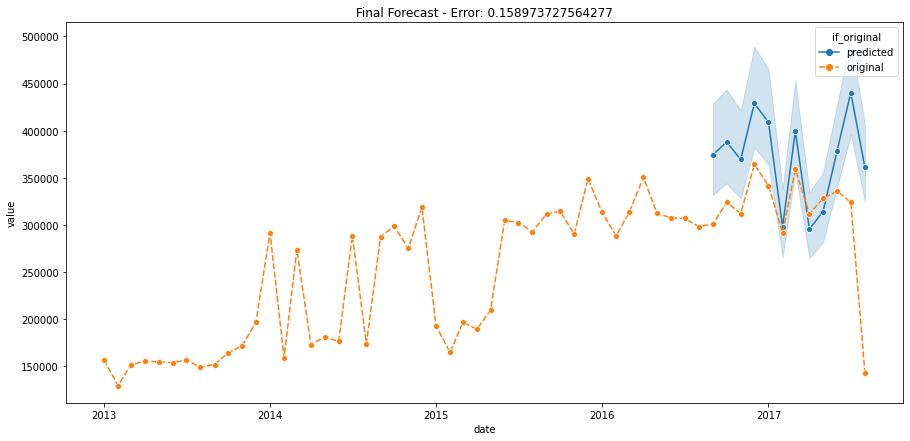

In [35]:
plt.figure(figsize=(15,7))
sns.lineplot(data=plot_data, x='date', y='value', hue='if_original', style='if_original', markers=['o', 'o'])
plt.title(f"Final Forecast - Error: {error}")
plt.show()